In [1]:
# ========================================
# 1. Import Libraries
# ========================================
import pandas as pd
import matplotlib.pyplot as plt

# Show plots inside notebook
%matplotlib inline

# ========================================
# 2. Load the IMDB CSV File
# ========================================
# Replace the filename with your uploaded file name
file_path = "IMDB.csv"   # <<--- change if needed

df = pd.read_csv(file_path)

# ========================================
# 3. Display the Dataset
# ========================================
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [2]:
import pandas as pd
import re

# Load your original file
df = pd.read_csv("IMDB.csv")

# Function to remove HTML tags like <br />, <br /><br />, etc.
def clean_html(text):
    return re.sub(r'<.*?>', '', text)

# Apply cleaning to the 'review' column
df['review'] = df['review'].apply(clean_html)

# Save cleaned file as IMDB2.csv
df.to_csv("IMDB2.csv", index=False)

print("Cleaning complete! File saved as IMDB2.csv")
df.head()


Cleaning complete! File saved as IMDB2.csv


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# ===========================================================
# LAB 1 — TEXT CLASSIFICATION USING RNN (LSTM)
# ===========================================================

# 1. IMPORT LIBRARIES
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# For plotting inside Jupyter
%matplotlib inline


# ===========================================================
# 2. LOAD THE DATASET
# ===========================================================
df = pd.read_csv("IMDB2.csv")
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# ===========================================================
# 3. SPLIT INTO TRAIN + TEST (80% / 20%)
# ===========================================================
X = df['review'].values
y = df['sentiment'].apply(lambda x: 1 if x == "positive" else 0).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

len(X_train), len(X_test)


(40000, 10000)

In [5]:
# ===========================================================
# 4. TEXT PREPROCESSING → TOKENIZATION
# ===========================================================
vocab_size = 20000   # max words to keep
oov_token = "<OOV>"  # unknown token

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

# Convert text → sequences of numbers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

# Pad all sequences to same length
max_length = 200      # set max review length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

X_train_pad.shape, X_test_pad.shape


((40000, 200), (10000, 200))

In [6]:
# ===========================================================
# 5. BUILD THE RNN MODEL (Embedding + LSTM)
# ===========================================================
embedding_dim = 64

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')   # binary classification
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,315,137
Trainable params: 1,315,137
Non-trainable params: 0
_________________________________________________________________


In [7]:
# ===========================================================
# 6. TRAIN THE MODEL
# ===========================================================
history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)


Epoch 1/5
250/250 [==============================] - 76s 285ms/step - loss: 0.6384 - accuracy: 0.6061 - val_loss: 0.4331 - val_accuracy: 0.8255
Epoch 2/5
250/250 [==============================] - 71s 283ms/step - loss: 0.4370 - accuracy: 0.8292 - val_loss: 0.4176 - val_accuracy: 0.8414
Epoch 3/5
250/250 [==============================] - 75s 301ms/step - loss: 0.5340 - accuracy: 0.7363 - val_loss: 0.6412 - val_accuracy: 0.5840
Epoch 4/5
250/250 [==============================] - 70s 282ms/step - loss: 0.5675 - accuracy: 0.6665 - val_loss: 0.5056 - val_accuracy: 0.8290
Epoch 5/5
250/250 [==============================] - 69s 277ms/step - loss: 0.5229 - accuracy: 0.6687 - val_loss: 0.6195 - val_accuracy: 0.6495


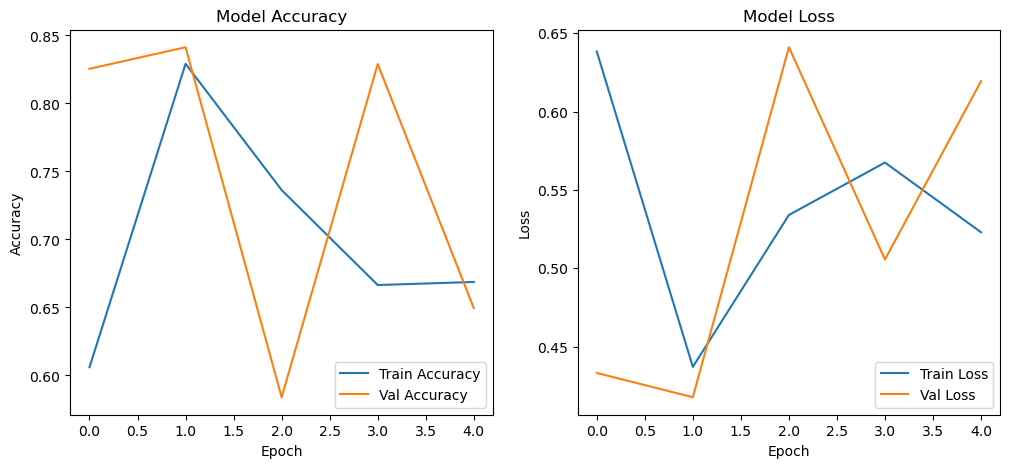

In [9]:
# ===========================================================
# 7. PLOT LOSS & ACCURACY
# ===========================================================

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [19]:
# ===========================================================
# 8. TEST FIRST 30 REVIEWS USING TRAINED RNN MODEL
# ===========================================================

# Take first 30 rows
df_test30 = df.head(150).copy()

# Convert to sequences
test_sequences = tokenizer.texts_to_sequences(df_test30['review'])
test_padded    = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Predict (returns values from 0–1)
pred_probs = model.predict(test_padded)

# Convert probabilities → labels
pred_labels = ["positive" if p >= 0.5 else "negative" for p in pred_probs]

# Add predictions to dataframe
df_test30["predicted_label"] = pred_labels

# Check if prediction matches true sentiment
df_test30["correct"] = df_test30.apply(
    lambda row: row["sentiment"] == row["predicted_label"], axis=1
)

# ===========================================================
# 9. CALCULATE ACCURACY ON FIRST 30 REVIEWS
# ===========================================================
accuracy_30 = df_test30["correct"].mean() * 100
print(f"Accuracy on first 150 reviews: {accuracy_30:.2f}%")

# ===========================================================
# 10. SAVE RESULTS INTO A NEW CSV FILE
# ===========================================================
df_test30.to_csv("IMDB_results.csv", index=False)

df_test30.head(10)


5/5 [==============================] - 0s 30ms/step
Accuracy on first 150 reviews: 73.33%


,review,sentiment,predicted_label,correct
0,One of the other reviewers has mentioned that ...,positive,positive,True
1,A wonderful little production. The filming tec...,positive,negative,False
2,I thought this was a wonderful way to spend ti...,positive,negative,False
3,Basically there's a family where a little boy ...,negative,negative,True
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,positive,True
5,"Probably my all-time favorite movie, a story o...",positive,negative,False
6,I sure would like to see a resurrection of a u...,positive,negative,False
7,"This show was an amazing, fresh & innovative i...",negative,negative,True
8,Encouraged by the positive comments about this...,negative,negative,True
9,If you like original gut wrenching laughter yo...,positive,negative,False


Lab Exercise 3 - Build a Simple RAG System (Retrieval + LLaMA)

In [2]:
!pip install sentence-transformers numpy pandas scikit-learn


     ---------------------------------------- 0.0/44.0 kB ? eta -:--:--
     ----------------- -------------------- 20.5/44.0 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 44.0/44.0 kB 535.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/493.7 kB ? eta -:--:--
   ----- ---------------------------------- 71.7/493.7 kB 2.0 MB/s eta 0:00:01
   ------------------- -------------------- 235.5/493.7 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 493.7/493.7 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/12.0 MB ? eta -:--:--
   - -------------------------------------- 0.4/12.0 MB 3.4 MB/s eta 0:00:04
   -- ------------------------------------- 0.7/12.0 MB 4.3 MB/s eta 0:00:03
   -- ------------------------------------- 0.9/12.0 MB 3.9 MB/s eta 0:00:03
   -- -----------

In [3]:
import os
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import subprocess


Load Text Documents

In [4]:
DOCS_FOLDER = "docs"

documents = []

for file in os.listdir(DOCS_FOLDER):
    if file.endswith(".txt"):
        with open(os.path.join(DOCS_FOLDER, file), "r", encoding="utf-8") as f:
            documents.append(f.read())

print(f"Loaded {len(documents)} documents")


Loaded 1 documents


Chunk Documents (200–300 Words)

In [6]:
def chunk_text(text, chunk_size=200):
    words = text.split()
    chunks = []
    
    for i in range(0, len(words), chunk_size):
        chunk = " ".join(words[i:i+chunk_size])
        chunks.append(chunk)
        
    return chunks

chunks = []
for doc in documents:
    chunks.extend(chunk_text(doc))

print(f"Total Chunks Created: {len(chunks)}")


Total Chunks Created: 2


In [7]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

chunk_embeddings = embedder.encode(
    chunks,
    convert_to_numpy=True,
    show_progress_bar=True
)

print("Embeddings shape:", chunk_embeddings.shape)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\hp\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hp\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings shape: (2, 384)


In [17]:
def retrieve_top_chunks(question, top_k=3):
    question_embedding = embedder.encode([question], convert_to_numpy=True)
    
    similarities = cosine_similarity(question_embedding, chunk_embeddings)[0]
    
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    return [chunks[i] for i in top_indices]


In [23]:
def ask_llama(prompt):
    result = subprocess.run(
        ["ollama", "run", "llama3.2"],
        input=prompt.encode("utf-8"),
        stdout=subprocess.PIPE
    )
    return result.stdout.decode("utf-8").strip()


In [24]:
def llama_no_rag(question):
    prompt = f"Answer the question clearly and short:\n{question}"
    return ask_llama(prompt)


In [25]:
def llama_with_rag(question):
    top_chunks = retrieve_top_chunks(question)
    
    context = "\n\n".join(top_chunks)
    
    prompt = f"""
Use ONLY the following context to answer the question.

Context:
{context}

Question: {question}
Answer:
"""
    return ask_llama(prompt)


In [26]:
questions = [
    "What is Artificial Intelligence?",
    "What is Natural Language Processing?",
    "What are Large Language Models?",
    "What is hallucination in LLMs?",
    "What is Retrieval-Augmented Generation?",
    "Why is chunking used in RAG systems?",
    "What are embeddings?",
    "How does similarity search work?",
    "Why does RAG reduce hallucinations?",
    "What are applications of RAG?"
]


In [27]:
print(ask_llama("What is Artificial Intelligence?"))


Artificial Intelligence (AI) refers to the development of computer systems that can perform tasks that would typically require human intelligence, such as:

1. Learning: AI systems can learn from data and improve their performance over time.
2. Problem-solving: AI systems can solve complex problems by analyzing data, identifying patterns, and making decisions.
3. Reasoning: AI systems can draw conclusions based on the information they have been trained on.
4. Perception: AI systems can interpret and understand data from sensors, such as images, speech, and text.

AI has many applications in various fields, including:

1. Virtual assistants (e.g., Siri, Alexa)
2. Image recognition and object detection
3. Natural Language Processing (NLP) for language translation and sentiment analysis
4. Predictive analytics and decision-making
5. Robotics and autonomous vehicles

There are several types of AI, including:

1. Narrow or Weak AI: Designed to perform a specific task, such as facial recogni

In [ ]:
results = []

for q in questions:
    print("\n" + "="*80)
    print("QUESTION:", q)
    
    no_rag_answer = llama_no_rag(q)
    rag_answer = llama_with_rag(q)
    
    print("\n--- LLaMA Alone ---")
    print(no_rag_answer)
    
    print("\n--- LLaMA + RAG ---")
    print(rag_answer)
    
    results.append({
        "Question": q,
        "LLaMA Alone": no_rag_answer,
        "LLaMA + RAG": rag_answer
    })



QUESTION: What is Artificial Intelligence?

--- LLaMA Alone ---
Artificial Intelligence (AI) refers to the development of computer systems that can perform tasks that typically require human intelligence, such as:

1. Learning: The ability to learn from data and improve performance over time.
2. Problem-solving: The ability to analyze problems and find solutions.
3. Reasoning: The ability to draw conclusions based on available information.
4. Perception: The ability to interpret and understand data from sensors.

AI systems use algorithms, machine learning models, and other techniques to process and analyze data, making decisions, and taking actions autonomously or with human oversight.

There are several types of AI, including:

1. Narrow or Weak AI: Designed to perform a specific task, such as facial recognition or language translation.
2. General or Strong AI: A hypothetical AI system that possesses the ability to understand, learn, and apply knowledge across a wide range of tasks,

In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("rag_comparison_results.csv", index=False)

df_results


In [ ]:
evaluation = pd.DataFrame({
    "Method": ["LLaMA Alone"] * 10 + ["LLaMA + RAG"] * 10,
    "Correct?": [""] * 20,
    "Notes": [""] * 20
})

evaluation
